# Face Mask Detection
## 1. Introduction
**Context**
This dataset is used for Face Mask Detection Classification with images. The dataset consists of almost 12K images which are almost 328.92MB in size.

**Acknowledgments**
All the images with the face mask (~6K) are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530). Thank you so much Jessica for providing a wonderful dataset to the community.

**Inspiration**
The inspiration behind creating this dataset is to create an algorithm that can directly detect is a person is wearing a face mask or not. So I've scrapped the images from google as well as from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530) to make this happen.




The dataset is donwloaded from kaggle [Face Mask Detection ~12K Images Dataset](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset)

## 2. Planning
1. Data Augmentation to increase dataset size
2. Develop and train CNN model to detect face
3. Label faces
    1. Using Haarcascade find and crop faces
    2. using CNN model to predict the result
    3. label the faces with predicted result


In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from libs.nn.conv import CnnModel
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.optimizers import SGD
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import opendatasets as od
import numpy as np
from imutils import paths
import os

In [2]:
# Dowload the dataset
dataset_url = 'https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset'

# Look into the data directory
images_dir = './face-mask-12k-images-dataset/Face Mask Dataset'

images_dir_path = pathlib.Path(images_dir)
if not os.path.isdir(images_dir):
    od.download(dataset_url)


## 3. Data Exploration

In [3]:
# Show random images
train_dir = f'{images_dir}/Train'
test_dir = f'{images_dir}/Test'
valid_dir = f'{images_dir}/Validation'

train_imgs = list(paths.list_images(train_dir))
test_imgs = list(paths.list_images(test_dir))
valid_imgs = list(paths.list_images(valid_dir))

len(train_imgs) + len(test_imgs) + len(valid_imgs)

11792

In [4]:
random_num_array = np.random.randint(len(train_imgs), size=16)

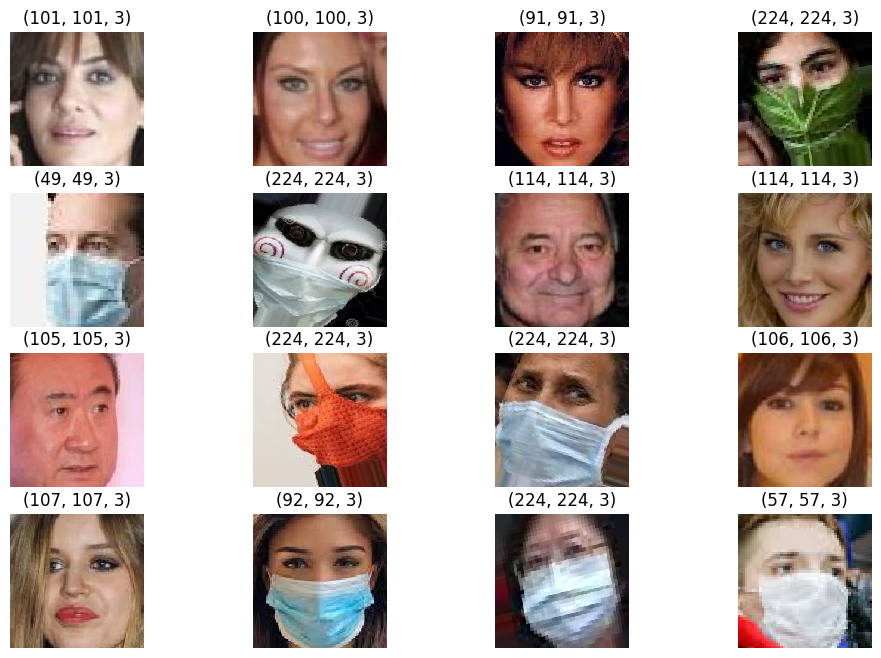

In [5]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))

for ax, num in zip(axs.ravel(), random_num_array):
    _img = img.imread(train_imgs[num])
    ax.set_title(f'{_img.shape}')
    ax.imshow(_img , interpolation='none')
    ax.axis("off")
# plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

Observation:
* we have have total 11792 different kind of colored images with different sizes

In [6]:
total_with_mask = len(list(paths.list_images(f'{images_dir}/Train/WithMask')))
total_without_mask = len(list(paths.list_images(f'{images_dir}/Train/WithoutMask')))
total_with_mask,total_without_mask

(5000, 5000)

## 4. Data Preparation

In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [8]:
train_data_set = keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
)
test_data_set = keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
)
valid_data_set = keras.utils.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
)

Found 10000 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


## 4. Training CNN Model

In [9]:
cnn_model = CnnModel.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth=3, classes=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

In [10]:
opt = SGD(learning_rate=0.005)
cnn_model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_data_set.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = valid_data_set.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [13]:
history = cnn_model.fit(train_ds, validation_data=val_ds,
	batch_size=32, epochs=100, verbose=1,callbacks=[early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 3s 4ms/step - loss: 1.0725 - accuracy: 0.7588 - val_loss: 0.3868 - val_accuracy: 0.8462
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 0.2150 - accuracy: 0.9235 - val_loss: 0.3820 - val_accuracy: 0.8500
Epoch 3/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1085 - accuracy: 0.9622 - val_loss: 0.1908 - val_accuracy: 0.9275
Epoch 4/100
313/313 [==============================] - 1s 4ms/step - loss: 0.0797 - accuracy: 0.9717 - val_loss: 1.5678 - val_accuracy: 0.5425
Epoch 5/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1072 - accuracy: 0.9604 - val_loss: 0.0755 - val_accuracy: 0.9800
Epoch 6/100
313/313 [==============================] - 1s 4ms/step - loss: 0.0567 - accuracy: 0.9804 - val_loss: 0.0420 - val_accuracy: 0.9837
Epoch 7/100
313/313 [==============================] - 1s 4ms/step - loss: 0.0524 - accuracy: 0.9813 - val_loss: 0.0402 - val_accuracy: 0.9875

## 5. Model Evaluation

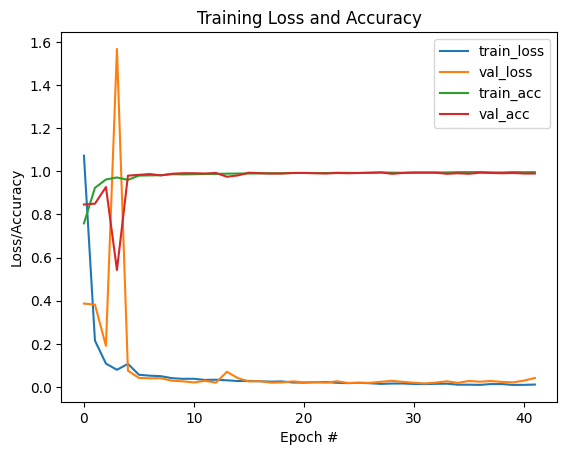

In [14]:
plt.figure()
plt.plot( history.history["loss"], label="train_loss")
plt.plot( history.history["val_loss"], label="val_loss")
plt.plot( history.history["accuracy"], label="train_acc")
plt.plot( history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [43]:
preds = np.array([])
testY =  np.array([])
for x, y in test_data_set:
    predict = cnn_model.predict(x)
    print(max(predict.argmax(axis=1)))
    preds = np.concatenate([preds, max(predict.argmax(axis=1))])
    testY = np.concatenate([testY, y])

tf.math.confusion_matrix(labels=testY, predictions=preds).numpy()


1/1 [==============================] - 0s 10ms/step
0


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [30]:
print(classification_report(testY,
	test_preds.argmax(axis=1),
	target_names=["WithMask", "WithoutMask"]))

ValueError: Found input variables with inconsistent numbers of samples: [31, 992]

## 6. Testing on new (real world) images

## 7. Save the Model

## 7. Future Work

## 8. Reference